In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import json

def read_json_data(file_path):
    try:
        with open(file_path, 'r') as json_file:
            data = json.load(json_file)
            return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        return None



def print_streaming_eval(json_data):
    # Accessing the 'id' field at the top level
    id_value = json_data.get('id')
    if id_value:
        print(f"ID: {id_value}")

    # Accessing fields within the 'runs' list
    runs = json_data.get('runs', [])
    for run in runs:
        range_value = run.get('range')
        slide_value = run.get('slide')
        systems = run.get('systems', [])

        print(f"Range: {range_value}, Slide: {slide_value}")

        for system in systems:
            system_id = system.get('id')
            throughput = system.get('throughput')
            runtime = system.get('runtime')

            print(f"System ID: {system_id}, Throughput: {throughput}, Runtime: {runtime}")

            # Accessing fields within 'insert_latency', 'query_latency', and 'advance_latency' dictionaries
            insert_latency = system.get('insert_latency', {})
            query_latency = system.get('query_latency', {})
            advance_latency = system.get('advance_latency', {})

            p50_insert = insert_latency.get('p50')
            p50_query = query_latency.get('p50')
            p50_advance = advance_latency.get('p50')

            sum_insert = insert_latency.get('sum')
            count_insert = insert_latency.get('count')
            avg_insert = sum_insert / count_insert

            print(f"AVG Insert: {avg_insert}, P50 Insert Latency: {p50_insert}, P50 Query Latency: {p50_query}, P50 Advance Latency: {p50_advance}")


# DEBS12 Streaming Window Aggregation

In [7]:
file_path = 'results/debs12.json' 
json_data = read_json_data(file_path)

if json_data:
    print_streaming_eval(json_data)

ID: debs12
Range: 30s, Slide: 2s
System ID: Lazy Wheel 64, Throughput: 16.21486527731696, Runtime: 1.9975816910000002
AVG Insert: 22.053459472306063, P50 Insert Latency: 21.116435486210896, P50 Query Latency: 15.959309654787097, P50 Advance Latency: 165.69029301849932
System ID: Lazy Wheel 512, Throughput: 16.32247663589858, Runtime: 1.984411969
AVG Insert: 22.069287190776016, P50 Insert Latency: 21.116435486210896, P50 Query Latency: 15.959309654787097, P50 Advance Latency: 165.69029301849932
System ID: Eager Wheel W64, Throughput: 16.049759002947397, Runtime: 2.018131113
AVG Insert: 22.11319840578036, P50 Insert Latency: 21.116435486210896, P50 Query Latency: 85.6353649471301, P50 Advance Latency: 175.93636042833486
System ID: Eager Wheel W512, Throughput: 16.176425976203216, Runtime: 2.002328453
AVG Insert: 22.094486911262116, P50 Insert Latency: 21.116435486210896, P50 Query Latency: 85.6353649471301, P50 Advance Latency: 175.93636042833486
System ID: FiBA Bfinger 4, Throughput: 5.

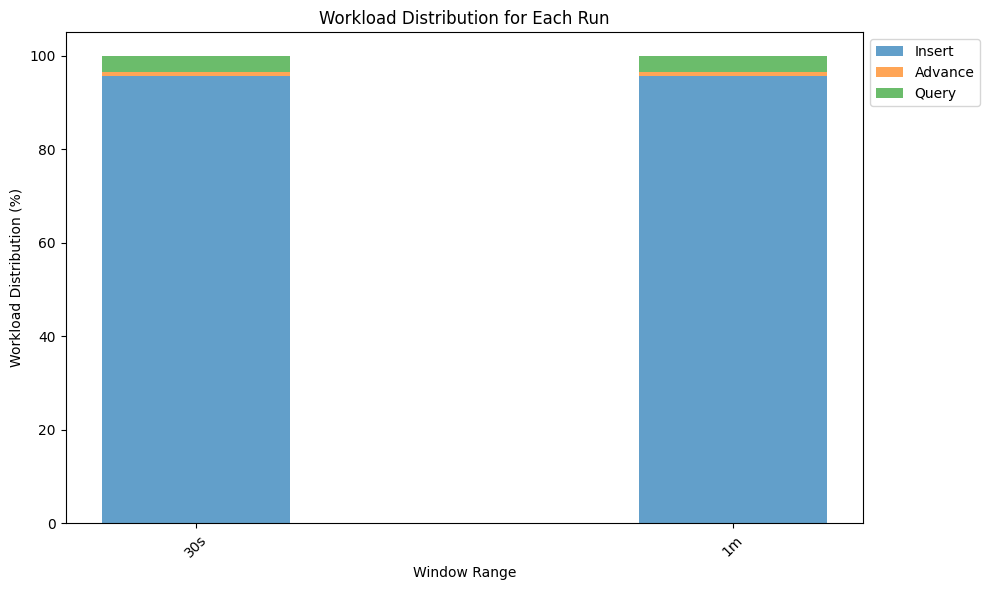

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_workload_distribution(json_data):
    runs = json_data.get('runs', [])

    # Initialize lists to store data for plotting
    x_labels = []  # Range values for the x-axis
    insert_distribution = []  # Data for insert distribution
    advance_distribution = []  # Data for advance distribution
    query_distribution = []  # Data for query distribution

    for run in runs:
        range_value = run.get('range')
        x_labels.append(range_value)

        systems = run.get('systems', [])
        insert_dist_sum = 0
        advance_dist_sum = 0
        query_dist_sum = 0

        system = systems[0]
        insert_dist = system.get('insert_distribution', 0)
        advance_dist = system.get('advance_distribution', 0)
        query_dist = system.get('query_distribution', 0)
        insert_dist_sum += insert_dist
        advance_dist_sum += advance_dist
        query_dist_sum += query_dist

        insert_distribution.append(insert_dist_sum)
        advance_distribution.append(advance_dist_sum)
        query_distribution.append(query_dist_sum)

    # Create stacked bar plots
    plt.figure(figsize=(10, 6))
    x_ticks = np.arange(len(x_labels))  # Custom x-axis tick positions

    #fig, ax = plt.subplots()
    bar_width = 0.35
    insert_bars = plt.bar(x_ticks, insert_distribution, width=bar_width, label='Insert', alpha=0.7)
    advance_bars = plt.bar(x_ticks, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.7)
    query_bars = plt.bar(x_ticks, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.7)
    #plt.bar(x_labels, insert_distribution, width=bar_width, label='Insert', alpha=0.7)
    #plt.bar(x_labels, advance_distribution, width=bar_width, bottom=insert_distribution, label='Advance', alpha=0.7)
    #plt.bar(x_labels, query_distribution, width=bar_width, bottom=np.array(insert_distribution) + np.array(advance_distribution), label='Query', alpha=0.7)
    

    
    # Add labels and legend
    plt.xlabel('Window Range')
    plt.ylabel('Workload Distribution (%)')
    plt.xticks(x_ticks, x_labels, rotation=45)

    plt.title('Workload Distribution for Each Run')
    #plt.legend(loc='upper right')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()


plot_workload_distribution(json_data)


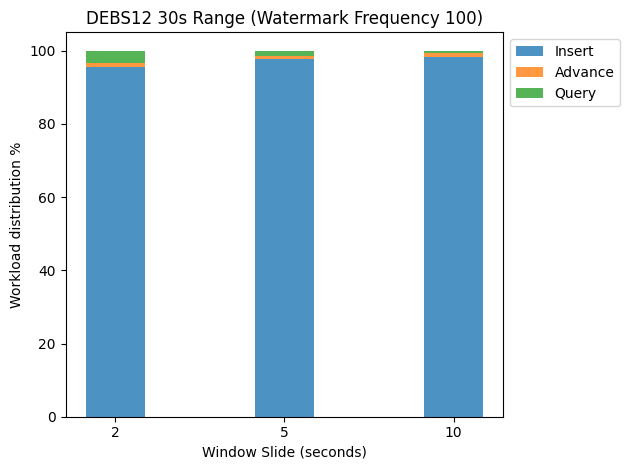

In [21]:
import matplotlib.pyplot as plt
import numpy as np

#Advance time 0.96%, Insert time 95.65%  Query time 3.39%
#Advance time 0.98%, Insert time 97.64%  Query time 1.38%
#Advance time 0.98%, Insert time 98.32%  Query time 0.70%


# Sample data
watermark_frequencies = ['2', '5', '10']
insert_operations = [95.65, 97.64, 98.32]
advance_operations = [0.96, 0.98, 0.98]
query_operations = [3.39, 1.38, 0.70]

# Create gigure and axis objects
fig, ax = plt.subplots()

# Stacked bar chart
bar_width = 0.35
index = np.arange(len(watermark_frequencies))

# Create bars for each option
plt.bar(index, insert_operations, bar_width, label='Insert', alpha=0.8)
plt.bar(index, advance_operations, bar_width, label='Advance', alpha=0.8, bottom=insert_operations)
plt.bar(index, query_operations, bar_width, label='Query', alpha=0.8, bottom=np.array(insert_operations) + np.array(advance_operations))

# Add labels, title, and legend
plt.xlabel('Window Slide (seconds)')
plt.ylabel('Workload distribution %')
plt.title('DEBS12 30s Range (Watermark Frequency 100)')
plt.xticks(index, watermark_frequencies)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.tight_layout()
plt.savefig("debs12.pdf", format="pdf", bbox_inches="tight")
plt.show()

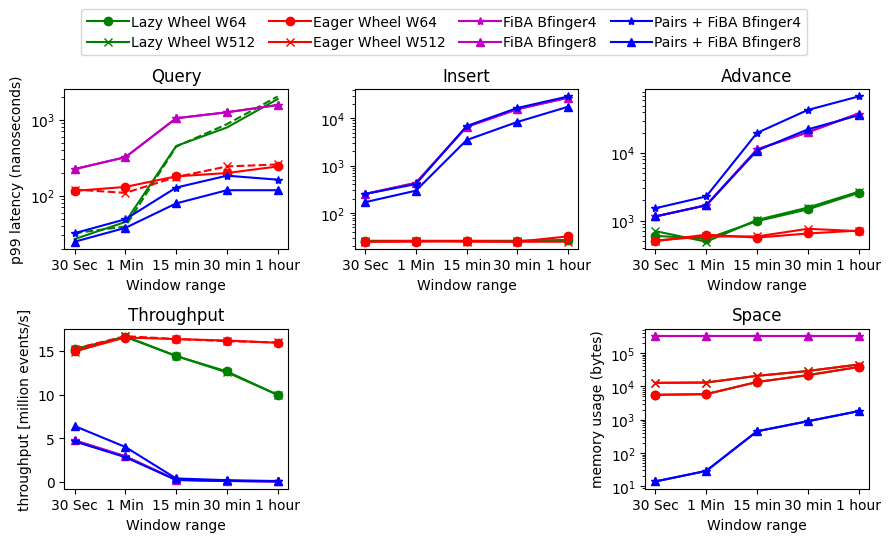

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import matplotlib.patches as pat
import matplotlib.path as pth
import matplotlib.patheffects as pff
import matplotlib.lines as lns
import matplotlib.transforms as tra

# TODO: read results from file and plot

st=plt.suptitle(r'')
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3,hspace=0.5)
x=['30 Sec','1 Min', '15 min', '30 min', '1 hour']

plt.subplot(2,3,1)
plt.title(r'Query')
plt.ylabel(r'p99 latency (nanoseconds)')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([26.844465437413014,45.153915815168446,450.4079269124312,788.531491561302,1863.4800488079172,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g')
y=np.array([32.138852969504235,39.254745374189724,441.4889580626803,871.4649775130857,2018.68922123101,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',linestyle='dashed')
y=np.array([115.59680764552776,130.33555804543147,179.4906303359779,198.36848598125036,242.28943126396913,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([120.31456328864704,108.8647558933244,175.93636042833486,242.28943126396913,257.27228753270765,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x', linestyle='dashed')
y=np.array([223.66073809127266,320.58336199659306,1043.3392628236475,1249.111376174664,1556.500034739868,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([223.66073809127266,320.58336199659306,1043.3392628236475,1249.111376174664,1556.500034739868,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([32.138852969504235,48.91478350453143,127.75465590591793,183.11670367609872,162.40929711714284,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([24.780498769903684,37.715494501758016,79.05119439536561,117.93209668887181,117.93209668887181,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,2)
plt.title(r'Insert')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([25.791844500743544,25.791844500743544,25.791844500743544,25.791844500743544,26.844465437413014,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([25.791844500743544,25.791844500743544,25.791844500743544,25.791844500743544,26.844465437413014,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([24.780498769903684,24.780498769903684,25.791844500743544,24.780498769903684,32.138852969504235,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([24.780498769903684,25.791844500743544,24.780498769903684,24.780498769903684,24.780498769903684,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x')
y=np.array([252.17778678948565,432.74660245747856,6569.828548905129,15526.005690315036,27181.45861441203,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([252.17778678948565,432.74660245747856,6569.828548905129,15526.005690315036,27181.45861441203,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([252.17778678948565,407.54458708463767,6837.9574561148,16486.113238019683,28862.323873246656,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([169.03757166533774,295.9349526303603,3464.1469140757617,8351.955779941116,17505.5925598655,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,3)
plt.title(r'Advance')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([595.9537183534419,539.2394262082521,982.5779489474648,1465.8535973546166,2566.277488622579,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([699.3618972397379,487.9223836052193,1022.6790794013975,1556.500034739868,2671.012821287514,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([497.77940145582954,620.2758780658565,561.2469530405447,645.5906777012347,713.4904204162985,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([507.83555098018996,584.1526546236706,584.1526546236706,757.6117193208825,699.3618972397379,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x')
y=np.array([1153.07205475692,1686.1408551087416,11274.07381697815,20136.318429988576,38188.9576200261,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([1153.07205475692,1686.1408551087416,11274.07381697815,20136.318429988576,38188.9576200261,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([1525.6782518737314,2276.074846082655,19737.579451176913,43058.101724074644,68208.26469914839,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([1153.07205475692,1686.1408551087416,10831.996616037934,22254.147710753925,35964.93392683659,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,4)
plt.title(r'Throughput')
plt.ylabel(r'throughput [million events/s]')
plt.xlabel(r'Window range')
y=np.array([15.249784923443933,16.62999881593632,14.44442126764091,12.670389243642921,9.97650238921368,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([14.939750534020545,16.703622690433306,14.441540737999492,12.56480806608148,9.991682792814617,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([14.992133891079995,16.56382759348927,16.381115798097593,16.215863135153338,15.961077952552603,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([15.269009289641138,16.716434793227684,16.392046593028358,16.141985315308155,15.99346879644346,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x', linestyle='dashed')
y=np.array([4.772945710638424,2.9388783005612846,0.2384517823909469,0.1197837208070601,0.060910846522763136,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([4.772945710638424,2.9388783005612846,0.2384517823909469,0.1197837208070601,0.060910846522763136,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([4.646441942800294,2.837291142674354,0.2247703023138991,0.11106391149996006,0.05530705487866415,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([6.410912381336375,4.008346776063395,0.3984282220024642,0.20249729513374778,0.1029318088446229,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')

plt.subplot(2,3,6)
plt.title(r'Space')
plt.ylabel(r'memory usage (bytes)')
plt.gca().set_yscale('log')
plt.xlabel(r'Window range')
y=np.array([5576,5832,13512,21704,38088,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W64',color='g',marker='o')
y=np.array([12744,13000,20680,28872,45256,],dtype=float)
plt.plot(x,y,label='Lazy Wheel W512',color='g',marker='x')
y=np.array([5576,5832,13512,21704,38088,],dtype=float)
plt.plot(x,y,label='Eager Wheel W64',color='r',marker='o')
y=np.array([12744,13000,20680,28872,45256,],dtype=float)
plt.plot(x,y,label='Eager Wheel W512',color='r',marker='x')
y=np.array([320642,320642,320642,320642,320642,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger4',color='m',marker='*')
y=np.array([320642,320642,320642,320642,320642,],dtype=float)
plt.plot(x,y,label='FiBA Bfinger8',color='m',marker='^')
y=np.array([14,29,449,899,1799,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger4',color='b',marker='*')
y=np.array([14,29,449,899,1799,],dtype=float)
plt.plot(x,y,label='Pairs + FiBA Bfinger8',color='b',marker='^')
coo=[-0.9,3,]
h,l=plt.gca().get_legend_handles_labels()
g=plt.legend(handlelength=3,ncol=4,loc='upper center',bbox_to_anchor=(-0.9, 3.0),borderaxespad=0.0,columnspacing=1,handletextpad=0.15)
plt.gcf().set_size_inches(10.377750103777501,5.1888750518887505)

plt.savefig("debs12.pdf", format="pdf", bbox_inches="tight")


# NYC Citi Bike Streaming Window Aggregation